In [1]:
import equinox as eqx
import inspect
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import frugal_flows

from frugal_flows.basic_flows import masked_independent_flow, masked_autoregressive_flow_first_uniform
from frugal_flows.bijections import UnivariateNormalCDF

import flowjax
from flowjax.distributions import Transformed, Uniform, _StandardUniform
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data
from flowjax.bijections.utils import Identity
from flowjax.wrappers import NonTrainable
from flowjax.bijections import (
    Affine,
    Invert,
    MaskedAutoregressive,
    RationalQuadraticSpline,
    Stack,
    Tanh,
)
import pandas as pd

SEED = 0

In [2]:
jax.config.update("jax_enable_x64", True)

# Generate data

In [3]:
# gen data
n_samples = 5000

key, subkey = jr.split(jr.PRNGKey(SEED))

y = jr.normal(subkey, shape=(n_samples,1)) #+ x


In [7]:
# INDEPENDENT Zs:

# continuous z
z = jr.multivariate_normal(key, jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(n_samples,))

# discrete z
key, subkey = jr.split(jr.PRNGKey(SEED - 2))


logit_args = jnp.array([2,3,4])
z_discr = jr.categorical(subkey, logits=jnp.array([jnp.log(logit_args[0]), jnp.log(logit_args[1]), jnp.log(logit_args[2])]), shape=(n_samples,))
z_discr_probs = jnp.array(logit_args)/logit_args.sum()

In [4]:
# DEPENDENT Zs

# continuous z
z = jr.multivariate_normal(key, jnp.array([0.,0.,0.]), jnp.array([[1., 0.8, 0.8],[0.8, 1.,0.8], [0.8, 0.8, 1.0]]), shape=(n_samples,))

In [5]:
z_cont = z[:,:2]

In [6]:
u_z_discr = jax.scipy.stats.norm.cdf(z[:,2])

In [7]:
z_discr_cdf = jnp.array([0.2, 0.6, 1.])

In [8]:
z_discr = jnp.digitize(u_z_discr, jnp.hstack([jnp.array(0.), z_discr_cdf]))-1

In [9]:
z_discr

Array([2, 0, 2, ..., 2, 1, 0], dtype=int32)

In [4]:
key = jr.PRNGKey(8)
# continuous z
z = jr.multivariate_normal(key, jnp.array([0.,0.,0.]), jnp.array([[9., 0.8, 0.8],[0.8, 9.,0.8], [0.8, 0.8, 9.0]]), shape=(n_samples,))
z_cont = z[:,:2]

# Independent Marginal flows (continuous)

In [5]:
from jaxtyping import ArrayLike, PRNGKeyArray, PyTree
import optax

In [6]:
def independent_continuous_marginal_flow(key: jr.PRNGKey,
                                            z_cont: ArrayLike,
                                            optimizer: optax.GradientTransformation | None = None,
                                            RQS_knots: int = 8,
                                            show_progress: bool = True,
                                            learning_rate: float = 5e-4,
                                            max_epochs: int = 100,
                                            max_patience: int = 5,
                                            batch_size: int = 100,
                                            val_prop: float = 0.1,
                                        ):
    nvars = z_cont.shape[1]
    key, subkey = jr.split(key)
    
    base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))
    
    transformer = RationalQuadraticSpline(knots=RQS_knots, interval=1)
    
    flow = masked_independent_flow(#masked_autoregressive_flow(
        key=subkey,
        base_dist=base_dist,
        transformer=transformer,
        ) # Support on [-1, 1]
    
    flow = Transformed(
        flow, Invert(Tanh(flow.shape))
    ) # Unbounded support
    
    
    flow = flow.merge_transforms()
    
    assert isinstance(flow.base_dist, _StandardUniform)
    
    flow = eqx.tree_at(
        where=lambda flow: flow.bijection.bijections[0],
        pytree=flow,
        replace_fn=NonTrainable,
        )
    
    key, subkey = jr.split(key)
    
    # Train 
    flow, losses = fit_to_data(
        key=subkey,
        dist=flow,
        x=z_cont,
        learning_rate=learning_rate,
        max_patience=max_patience,
        max_epochs=max_epochs,
        batch_size=batch_size,
        show_progress=show_progress,
        optimizer=optimizer,
        val_prop=val_prop,
    )

    return flow, losses
    

In [16]:
flow, losses = independent_continuous_marginal_flow(
    key=jr.PRNGKey(8),
    z_cont=z_cont,#jnp.array(df[['Z3', 'Z4']].values),#z_cont,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=70,
)

 59%|██████████████████████████████████████                           | 41/70 [00:11<00:08,  3.60it/s, train=inf, val=5.108449 (Max patience reached)]


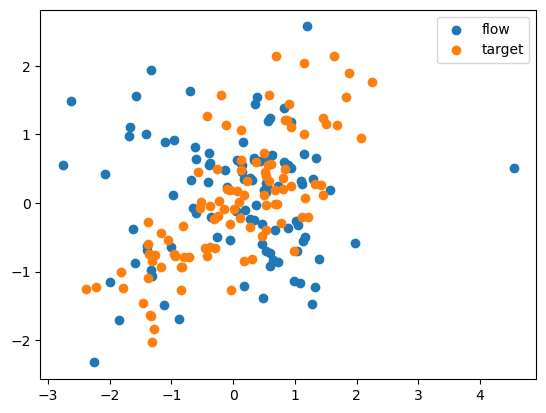

In [17]:
plt.scatter(*flow.sample(key, (100, )).T, label="flow")
plt.scatter(*z_cont[:100].T, label="target")
plt.legend()

In [18]:
marginal_cdf = jax.vmap(flow.bijection.inverse, in_axes=(0,))

In [19]:
u_z_cont = marginal_cdf(z_cont)

# Independent marginals (discrete)

In [20]:
def univariate_discrete_cdf(key: jr.PRNGKey,
                           z_discr: ArrayLike,
                           max_unique_z_discr_size: int,
                          ):

    n_samples = z_discr.shape[0]
    pmf_keys, pmf_vals = jnp.unique(z_discr, return_counts=True, size=max_unique_z_discr_size)
    # assert pmf_keys.all() == jnp.arange(max(pmf_keys)+1).all() # check increasing order is respected
    z_discr_empirical_pmf = pmf_vals/n_samples
    z_discr_empirical_cdf_long = z_discr_empirical_pmf.cumsum()

    def uniform_shift(standard_uniform, upper_index):
        # Function to handle the case where upper_index != 0
        def not_zero():
            lower = z_discr_empirical_cdf_long[upper_index - 1]
            upper = z_discr_empirical_cdf_long[upper_index]
            return standard_uniform * (upper - lower) + lower
    
        # Function to handle the case where upper_index == 0
        def zero():
            upper = z_discr_empirical_cdf_long[upper_index]
            return standard_uniform * upper
    
        # Using lax.cond to select which function to use
        return jax.lax.cond(upper_index != 0, not_zero, zero)

    uniforms = jr.uniform(key, (n_samples,))
    vmapped_uniform_shift = jax.vmap(uniform_shift)
    u_z_discr = vmapped_uniform_shift(uniforms, z_discr)

    return u_z_discr, z_discr_empirical_cdf_long

In [21]:
u_z_discr, z_discr_empirical_cdf_long = univariate_discrete_cdf(key=jr.PRNGKey(909),
                           z_discr=z_discr,
                           max_unique_z_discr_size=len(jnp.unique(z_discr)),
                          )

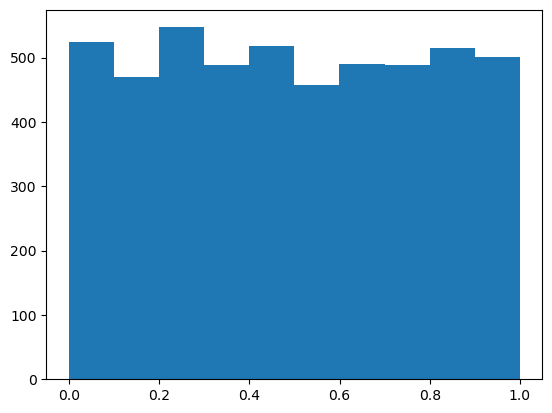

In [22]:
plt.hist(u_z_discr);

# Independent marginals (mixed)

In [26]:
def get_independent_quantiles(key: jr.PRNGKey,
                                z_discr: ArrayLike | None = None, #impose discrete
                                z_cont: ArrayLike | None = None,
                                optimizer: optax.GradientTransformation | None = None,
                                RQS_knots: int = 8,
                                show_progress: bool = True,
                                learning_rate: float = 5e-4,
                                max_epochs: int = 100,
                                max_patience: int = 5,
                                batch_size: int = 100,
                                return_z_cont_flow = False,
                             ):

    assert ((z_discr is not None)|(z_cont is not None))
    res = {}
    
    key, subkey = jr.split(key)

    if z_cont is not None:
        z_cont_flow, z_cont_losses = independent_continuous_marginal_flow(
                    key=key,
                    z_cont=z_cont,
                    optimizer=optimizer,
                    RQS_knots=RQS_knots,
                    show_progress=show_progress,
                    learning_rate=learning_rate,
                    max_epochs=max_epochs,
                    max_patience=max_patience,
                    batch_size=batch_size,
                    )
        z_cont_marginal_cdf = jax.vmap(z_cont_flow.bijection.inverse, in_axes=(0,))
        
        u_z_cont = marginal_cdf(z_cont)
        res['u_z_cont'] = u_z_cont

        if return_z_cont_flow:
            res['z_cont_flow'] = z_cont_flow

    if z_discr is not None:
        n_discr = z_discr.shape[1]
        keys = jr.split(key, n_discr)
        vmapped_get_discrete_quantiles = jax.vmap(univariate_discrete_cdf, in_axes=(0,1, None))
        u_z_discr_T, z_discr_empirical_cdf_long = vmapped_get_discrete_quantiles(keys, z_discr, len(jnp.unique(z_discr)))
        
        res['z_discr_empirical_cdf_long'] = z_discr_empirical_cdf_long
        res['u_z_discr'] = u_z_discr_T.T

    return res
        

In [27]:
# logit_args = jnp.array([2,3,4])
# z_discr = jr.categorical(subkey, logits=jnp.array([jnp.log(logit_args[0]), 
#                                                    jnp.log(logit_args[1]), 
#                                                    jnp.log(logit_args[2])]), shape=(n_samples,2))



In [28]:
res = get_independent_quantiles(key = jr.PRNGKey(3),
                                z_discr=jnp.expand_dims(z_discr,axis=1), #impose discrete
                                z_cont=z_cont,
                                max_epochs = 70,
                                max_patience=10,
                                return_z_cont_flow = True,
                             )

 33%|████████████▍                         | 23/70 [00:09<00:19,  2.39it/s, train=2.8009534, val=2.9194877 (Max patience reached)]


In [29]:
res['u_z_discr'].shape

(5000, 1)

In [30]:
res['z_discr_empirical_cdf_long']

Array([[0.1942, 0.5954, 1.    ]], dtype=float32)

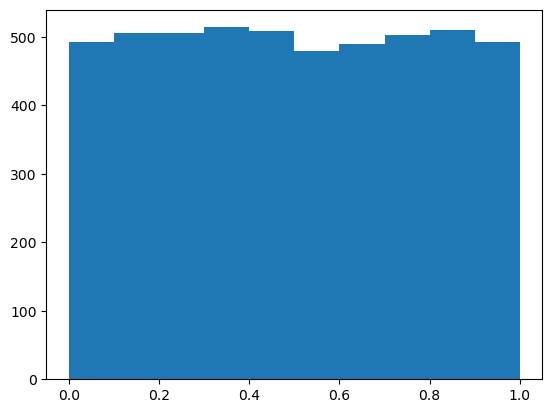

In [31]:
plt.hist(res['u_z_discr'][:,0]);

# Copula flow given marginal

In [32]:
def train_copula_flow(key: jr.PRNGKey,
                u_z: ArrayLike, #impose discrete
                optimizer: optax.GradientTransformation | None = None,
                RQS_knots: int = 8,
                show_progress: bool = True,
                learning_rate: float = 5e-4,
                max_epochs: int = 100,
                max_patience: int = 5,
                batch_size: int = 100,
             ):


    nvars = u_z.shape[1]
    key, subkey = jr.split(key)
    
    base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))
    
    transformer = RationalQuadraticSpline(knots=RQS_knots, interval=1)
    
    copula_flow = masked_autoregressive_flow(#masked_autoregressive_flow(
        key=subkey,
        base_dist=base_dist,
        transformer=transformer,
        ) # Support on [-1, 1]
    
    copula_flow = Transformed(
        copula_flow, Invert(Affine(loc=-jnp.ones(nvars), scale=jnp.ones(nvars)*2))
    ) # Unbounded support
    
    
    copula_flow = copula_flow.merge_transforms()
    
    assert isinstance(copula_flow.base_dist, _StandardUniform)
    
    copula_flow = eqx.tree_at(
        where=lambda copula_flow: copula_flow.bijection.bijections[0],
        pytree=copula_flow,
        replace_fn=NonTrainable,
        )
    
    copula_flow = eqx.tree_at(
        where=lambda copula_flow: copula_flow.bijection.bijections[-1],
        pytree=copula_flow,
        replace_fn=NonTrainable,
        )
    
    key, subkey = jr.split(key)
    
    # Train 
    copula_flow, losses = fit_to_data(
        key=subkey,
        dist=copula_flow,
        x=u_z,
        optimizer=optimizer,
        show_progress=show_progress,
        learning_rate=learning_rate,
        max_epochs=max_epochs,
        max_patience=max_patience,
        batch_size=batch_size,
    )

    return copula_flow, losses

In [33]:
u_z = jnp.hstack([res['u_z_cont'],res['u_z_discr'] ])

In [34]:
copula_flow, losses = get_copula_flow(key=jr.PRNGKey(SEED + 2),
                        u_z=u_z,
                        learning_rate=1e-3,
                        max_epochs=150,
                        max_patience=50,
                     )

 56%|███████████████████               | 84/150 [00:28<00:22,  2.94it/s, train=-0.9865468, val=-0.90934193 (Max patience reached)]


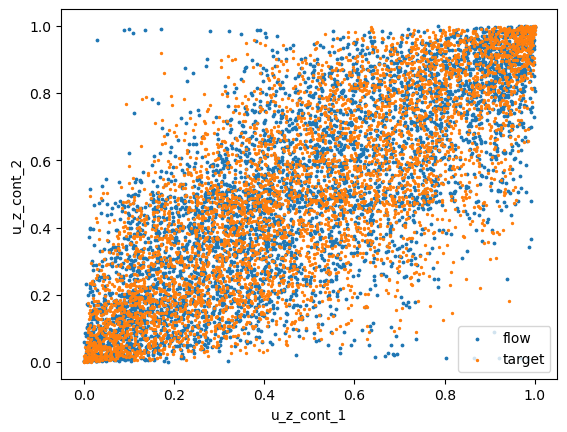

In [35]:
plt.scatter(*copula_flow.sample(key, (5000, ))[:,:2].T, label="flow", s=3)
plt.scatter(*u_z[:,:2].T, label="target", s=2)
plt.legend()
plt.xlabel('u_z_cont_1')
plt.ylabel('u_z_cont_2')
plt.show()

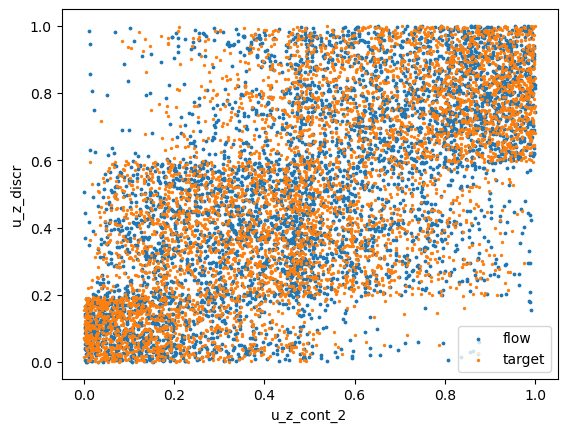

In [36]:
plt.scatter(*copula_flow.sample(key, (5000, ))[:,1:3].T, label="flow", s=3)
plt.scatter(*u_z[:,1:3].T, label="target", s=2)
plt.legend()
plt.xlabel('u_z_cont_2')
plt.ylabel('u_z_discr')
plt.show()

In [37]:
inv_copula_cdf = jax.vmap(copula_flow.bijection.inverse, in_axes=(0,))
uu = inv_copula_cdf(u_z)

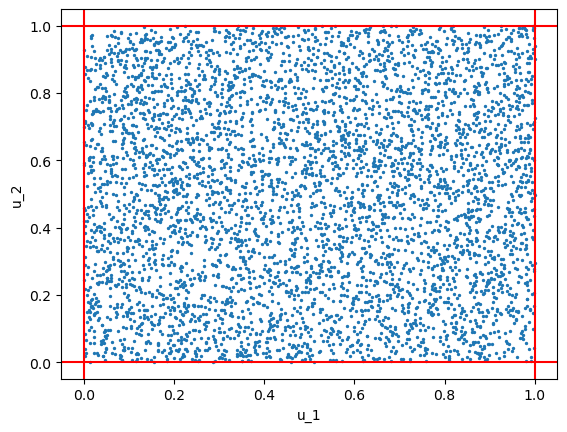

In [38]:
plt.scatter(*(uu[:,:2].T), label="inverse flow", s=2,)
plt.xlabel('u_1')
plt.ylabel('u_2')
plt.axhline(0, color='red')
plt.axhline(1, color='red')
plt.axvline(0, color='red')
plt.axvline(1, color='red')
plt.show()

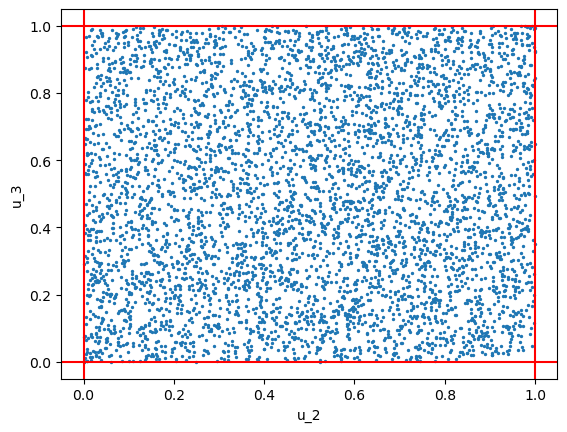

In [39]:
plt.scatter(*(uu[:,1:3].T), label="inverse flow", s=2,)
plt.xlabel('u_2')
plt.ylabel('u_3')
plt.axhline(0, color='red')
plt.axhline(1, color='red')
plt.axvline(0, color='red')
plt.axvline(1, color='red')
plt.show()

# copula flow + marginal Y given other marginals

In [25]:
u_z_all = jnp.hstack([u_z_cont, jnp.expand_dims(u_z_discr, axis=1)])

In [26]:
u_z_all.shape

(5000, 3)

In [27]:
list_bijections = [UnivariateNormalCDF(ate=5., scale=2., const=1.)] + [Identity(())]*3  


marginal_transform = Stack(list_bijections)

nvars = 3
key, subkey = jr.split(jr.PRNGKey(SEED + 3))

base_dist = Uniform(-jnp.ones(nvars+1), jnp.ones(nvars+1))

transformer = RationalQuadraticSpline(knots=8, interval=1)

copula_flow = masked_autoregressive_flow_first_uniform(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    invert=True,
    # cond_dim=x.shape[1],
    ) # Support on [-1, 1]

copula_flow = Transformed(
    copula_flow, Invert(Affine(loc=-jnp.ones(nvars+1), scale=jnp.ones(nvars+1)*2))
) # Unbounded support



copula_flow = Transformed(
    copula_flow, Invert(marginal_transform),
) # Unbounded support


copula_flow = copula_flow.merge_transforms()

assert isinstance(copula_flow.base_dist, _StandardUniform)

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[0],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[-2],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
copula_flow, losses = fit_to_data(
    key=subkey,
    dist=copula_flow,
    x=jnp.hstack([y, u_z_all]),
    learning_rate=1e-3,
    max_patience=70,
    max_epochs=300,
)

 38%|███████████                  | 115/300 [00:36<00:58,  3.14it/s, train=0.40940967, val=0.5594512 (Max patience reached)]


### samples from the copula flow 

In [28]:
copula_flow_samples = copula_flow.sample(key, (5000,))#, condition=u_1) #
copula_flow_samples.shape

(5000, 4)

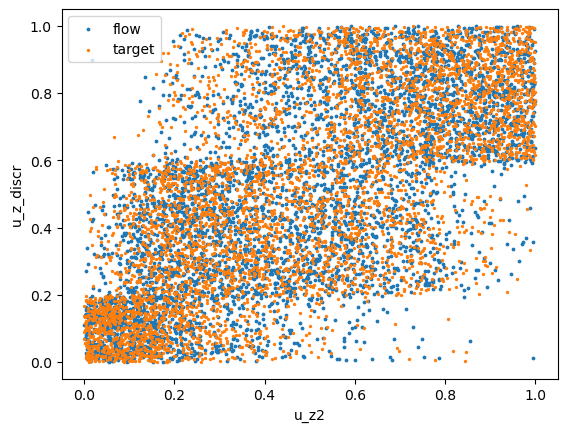

In [29]:
plt.scatter(*copula_flow_samples[:,2:4].T, label="flow", s=3)
plt.scatter(*u_z_all[:,1:3].T, label="target", s=2)
plt.xlabel('u_z2')
plt.ylabel('u_z_discr')
plt.legend()
plt.show()

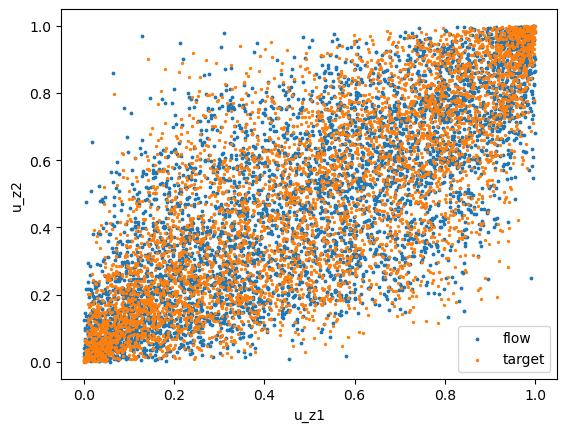

In [30]:
plt.scatter(*copula_flow_samples[:,1:3].T, label="flow", s=3)
plt.scatter(*u_z_cont[:,:2].T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

In [47]:
z_all = jnp.hstack([z_cont, jnp.expand_dims(z_discr, axis=1)])

In [59]:
jnp.corrcoef((z_all).T)

Array([[1.        , 0.79570824, 0.7065021 ],
       [0.79570824, 1.        , 0.71416837],
       [0.7065021 , 0.71416837, 1.        ]], dtype=float32)

In [70]:
z_discr_flow_samples = jnp.digitize(copula_flow_samples[:,3], jnp.hstack([jnp.array(0.), z_discr_cdf]))-1
simulated_z = jnp.hstack([jax.scipy.special.ndtri(copula_flow_samples[:,1:3]), jnp.expand_dims(z_discr_flow_samples, axis=1)])

In [71]:
jnp.corrcoef(simulated_z.T)

Array([[1.        , 0.77134407, 0.67023516],
       [0.77134407, 1.        , 0.6847221 ],
       [0.67023516, 0.6847221 , 0.9999999 ]], dtype=float32)

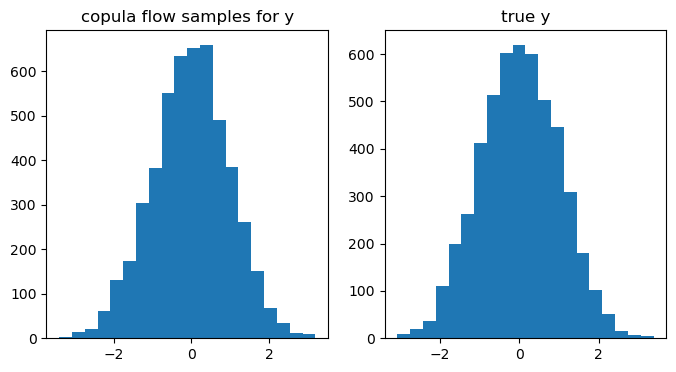

In [33]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].hist(copula_flow_samples[:,0], label="flow", bins=20)
ax[0].set_title('copula flow samples for y')

ax[1].hist(y.flatten(), label="flow", bins=20)
ax[1].set_title('true y')
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [34]:
copula_flow.bijection.bijections[-1].bijection.bijections[0].ate, copula_flow.bijection.bijections[-1].bijection.bijections[0].scale


(Array(5., dtype=float32), Array(0.9963957, dtype=float32))

In [35]:
copula_flow.bijection.bijections[-1].bijection.bijections[0].const

Array(0.00360352, dtype=float32)

### pushing base distribution through the flow

In [19]:
uni_s = jr.uniform(key, shape=(5000,3))

In [20]:
uni_m1p1 = jax.vmap(copula_flow.bijection.bijections[0].tree.transform)(uni_s)
corruni_m1p1 = jax.vmap(copula_flow.bijection.bijections[1].transform)(uni_m1p1) #, u_1)#, x)

In [21]:
corruni_01 = jax.vmap(copula_flow.bijection.bijections[2].tree.transform)(corruni_m1p1) #, u_1) #, x)

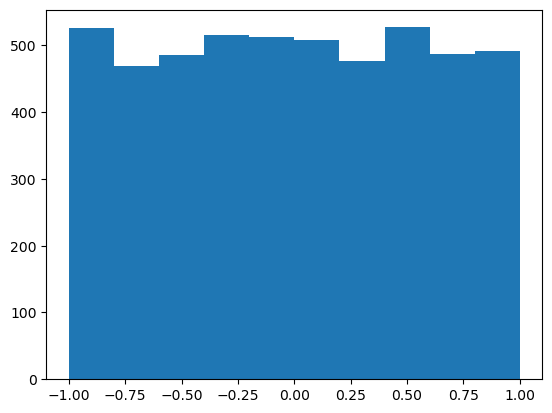

In [22]:
plt.hist(corruni_m1p1[:,0]);

# Frugal flow with X conditioning

In [40]:
# keys = jr.split(jr.PRNGKey(SEED+6), 3)

# N = 10000

# z_0 = jr.multivariate_normal(keys[0], jnp.array([0.,0.]), jnp.array([[1., 0],[0, 1.]]), shape=(int(N/2),))

# z_1 = jr.multivariate_normal(keys[1], jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(int(N/2),))
# z = jnp.vstack([z_0, z_1])

# x = jnp.expand_dims(jnp.hstack([jnp.ones(int(N/2))*0, jnp.ones(int(N/2))*1]),axis=1)
# y = jax.random.normal(keys[2], shape=(N,1)) + x + jnp.expand_dims(z.sum(1), axis=1)

In [41]:
keys = jr.split(jr.PRNGKey(SEED+6), 3)

N = 10000

z = jr.multivariate_normal(keys[0], jnp.array([0.,0.]), jnp.array([[1., 0],[0, 1.]]), shape=(N,))


x = jnp.expand_dims(jnp.hstack([jnp.ones(int(N/2))*0, jnp.ones(int(N/2))*1]),axis=1)
y = jax.random.normal(keys[2], shape=(N,1)) + x + jnp.expand_dims(z.sum(1), axis=1)

In [42]:
u_z = jax.scipy.stats.norm.cdf(z, loc=0, scale=1)

In [43]:
def train_frugal_flow(key: jr.PRNGKey,
                y: ArrayLike,
                u_z: ArrayLike, #impose discrete
                optimizer: optax.GradientTransformation | None = None,
                RQS_knots: int = 8,
                show_progress: bool = True,
                learning_rate: float = 5e-4,
                max_epochs: int = 100,
                max_patience: int = 5,
                batch_size: int = 100,
                condition: ArrayLike|None = None,
             ):
    
    nvars = u_z.shape[1]
    key, subkey = jr.split(key)
    
    list_bijections = [UnivariateNormalCDF(ate=5., scale=2., const=5., cond_dim=x.shape[1])] + [Identity(())]*nvars  
    marginal_transform = Stack(list_bijections)
    
    base_dist = Uniform(-jnp.ones(nvars+1), jnp.ones(nvars+1))
    
    transformer = RationalQuadraticSpline(knots=RQS_knots, interval=1)
    
    frugal_flow = masked_autoregressive_flow_first_uniform(#masked_autoregressive_flow(
        key=subkey,
        base_dist=base_dist,
        transformer=transformer,
        invert=True,
        cond_dim_mask=condition.shape[1],
        # cond_dim_nomask=x.shape[1],
        # cond_dim=x.shape[1],
        ) # Support on [-1, 1]
    
    frugal_flow = Transformed(
        frugal_flow, Invert(Affine(loc=-jnp.ones(nvars+1), scale=jnp.ones(nvars+1)*2))
    ) 
    
    frugal_flow = Transformed(
        frugal_flow, Invert(marginal_transform),
    )
    
    frugal_flow = frugal_flow.merge_transforms()
    
    assert isinstance(frugal_flow.base_dist, _StandardUniform)
    
    frugal_flow = eqx.tree_at(
        where=lambda frugal_flow: frugal_flow.bijection.bijections[0],
        pytree=frugal_flow,
        replace_fn=NonTrainable,
        )
    
    frugal_flow = eqx.tree_at(
        where=lambda frugal_flow: frugal_flow.bijection.bijections[-2],
        pytree=frugal_flow,
        replace_fn=NonTrainable,
        )
    
    key, subkey = jr.split(key)
    
    # Train 
    frugal_flow, losses = fit_to_data(
        key=subkey,
        dist=frugal_flow,
        x=jnp.hstack([y, u_z]),
        condition=condition,
        optimizer=optimizer,
        show_progress=show_progress,
        learning_rate=learning_rate,
        max_epochs=max_epochs,
        max_patience=max_patience,
        batch_size=batch_size,
    )

    return frugal_flow, losses

In [45]:
frugal_flow, losses = train_frugal_flow(key=subkey,
                y=y,
                u_z=u_z,
                learning_rate=1e-3,
                max_patience=70,
                max_epochs=300,
                condition=x,
             )

 62%|██████████████▉         | 186/300 [01:21<00:49,  2.29it/s, train=1.9439557, val=1.9915498 (Max patience reached)]


### samples from the copula flow 

In [46]:
frugal_flow_samples = frugal_flow.sample(key, condition=jnp.ones((10000,1))) #
frugal_flow_samples.shape

(10000, 3)

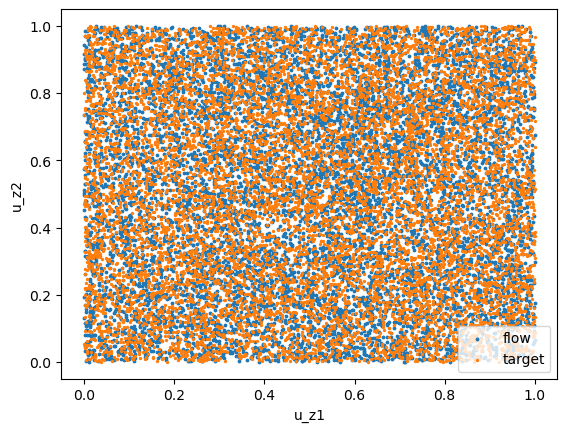

In [47]:
plt.scatter(*frugal_flow_samples[:,1:].T, label="flow", s=3)
plt.scatter(*u_z.T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

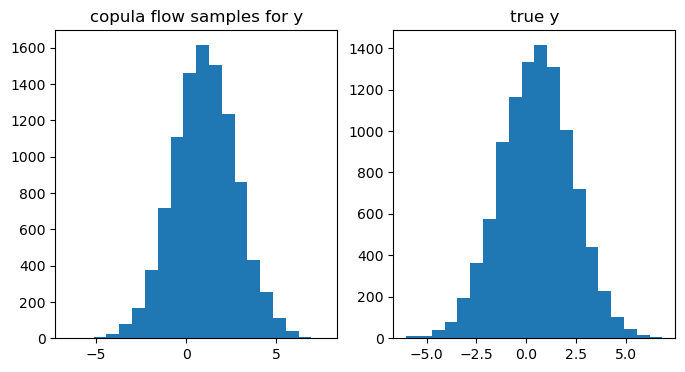

In [48]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].hist(frugal_flow_samples[:,0], label="flow", bins=20)
ax[0].set_title('copula flow samples for y')

ax[1].hist(y.flatten(), label="flow", bins=20)
ax[1].set_title('true y')
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [49]:
frugal_flow.bijection.bijections[-1].bijection.bijections[0].ate, frugal_flow.bijection.bijections[-1].bijection.bijections[0].scale

(Array(1.0207697, dtype=float32), Array(1.7152127, dtype=float32))

In [50]:
frugal_flow.bijection.bijections[-1].bijection.bijections[0].const

Array(0.00360785, dtype=float32)

In [51]:
n_samples = 10000
frugal_flow_samples_1 = frugal_flow.sample(key, condition=jnp.ones((n_samples,1)))
frugal_flow_samples_0 = frugal_flow.sample(key, condition=jnp.zeros((n_samples,1)))

In [52]:
print(frugal_flow_samples_1[:,0].mean())

1.0375897


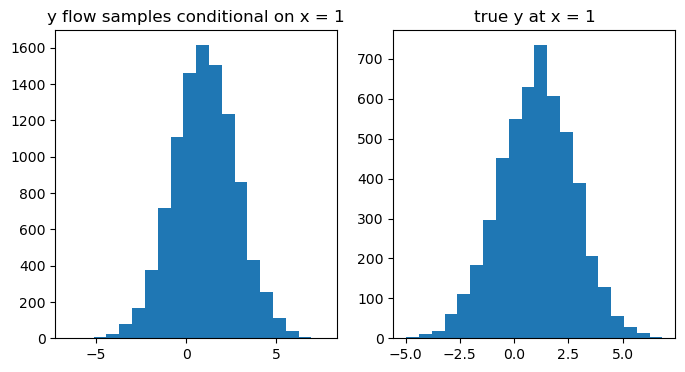

In [53]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].set_title('y flow samples conditional on x = 1')
ax[0].hist(frugal_flow_samples_1[:,0], label="flow", bins=20)

ax[1].set_title('true y at x = 1')
ax[1].hist(y[x==1], label="flow", bins=20)
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [54]:
print(frugal_flow_samples_0[:,0].mean())

0.01682004


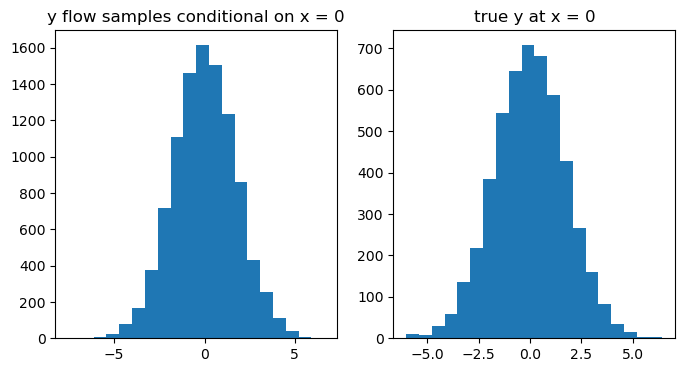

In [55]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].set_title('y flow samples conditional on x = 0')
ax[0].hist(frugal_flow_samples_0[:,0], label="flow", bins=20)

ax[1].set_title('true y at x = 0')
ax[1].hist(y[x==0], label="flow", bins=20)
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

## Simulate from user-defined treatment effect after training

In [56]:
def simulate_parametric(frugal_flow,
             key: jr.PRNGKey,
            n_samples: float,
            flow_dim: int,
            causal_cdf: UnivariateNormalCDF, 
            causal_condition: ArrayLike|None = None,
            **treatment_kwargs: dict):

    if frugal_flow.cond_shape is None:
        flow_fake_condition = None
    else:    
       flow_fake_condition = jnp.ones((n_samples,frugal_flow.cond_shape[0]))
    
    uni_standard = jr.uniform(key, shape=(n_samples, flow_dim))
    uni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[0].tree.transform)(uni_standard)

    corruni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[1].transform)(uni_minus1_plus1, flow_fake_condition)
    corruni_standard = jax.vmap(frugal_flow.bijection.bijections[2].tree.transform)(corruni_minus1_plus1, flow_fake_condition)
    u_y = corruni_standard[:,0]

    if causal_condition is not None:
        treatment_kwargs['cond_dim'] = causal_condition.shape[1]
    else:
        treatment_kwargs['cond_dim'] = None
        
    causal_cdf_init_params = [i for i in inspect.signature(causal_cdf.__init__).parameters.keys() if ((i != 'self') and (i != 'cond_dim'))]
    for param in causal_cdf_init_params:
        if param not in treatment_kwargs.keys():
            treatment_kwargs[param] = None

    for k,v in treatment_kwargs.items():
        if k != 'cond_dim':
            if v is None:
                treatment_kwargs[k] = getattr(frugal_flow.bijection.bijections[-1].bijection.bijections[0], k)

    causal_cdf_simulate = causal_cdf(**treatment_kwargs)
    samples = jax.vmap(causal_cdf_simulate.inverse)(u_y, causal_condition)
    return samples, causal_cdf_simulate
    
    

In [483]:
n_samples = 200
if frugal_flow.cond_shape is None:
    flow_fake_condition = None
else:    
   flow_fake_condition = jnp.ones((n_samples,frugal_flow.cond_shape[0]))

In [485]:
flow_fake_condition.shape

(200, 1)

In [487]:
flow_dim = 3
uni_standard = jr.uniform(key, shape=(n_samples, flow_dim))
uni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[0].tree.transform)(uni_standard)

corruni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[1].transform)(uni_minus1_plus1, flow_fake_condition)
corruni_standard = jax.vmap(frugal_flow.bijection.bijections[2].tree.transform)(corruni_minus1_plus1, flow_fake_condition)
u_y = corruni_standard[:,0]

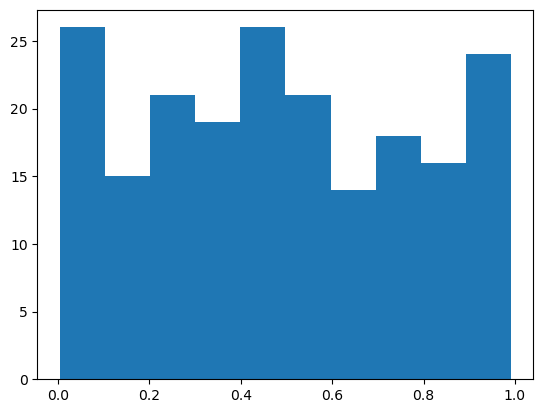

In [489]:
plt.hist(u_y);

In [490]:
treatment_kwargs={'ate':5, 'const':0., 'scale':1.}

In [492]:
if x is not None:
    treatment_kwargs['cond_dim'] = x.shape[1]
else:
    treatment_kwargs['cond_dim'] = None
    

In [493]:
treatment_kwargs

{'ate': 5, 'const': 0.0, 'scale': 1.0, 'cond_dim': 1}

In [495]:
causal_cdf_init_params = [i for i in inspect.signature(UnivariateNormalCDF.__init__).parameters.keys() if ((i != 'self') and (i != 'cond_dim'))]
for param in causal_cdf_init_params:
    if param not in treatment_kwargs.keys():
        treatment_kwargs[param] = None

In [498]:
treatment_kwargs


{'ate': 5, 'const': 0.0, 'scale': 1.0, 'cond_dim': 1}

In [497]:
for k,v in treatment_kwargs.items():
    if k != 'cond_dim':
        if v is None:
            treatment_kwargs[k] = getattr(frugal_flow.bijection.bijections[-1].bijection.bijections[0], k)

In [501]:
causal_cdf = UnivariateNormalCDF

In [502]:
causal_cdf_simulate = causal_cdf(**treatment_kwargs)

In [503]:
causal_cdf_simulate

UnivariateNormalCDF(
  shape=(),
  cond_shape=(1,),
  ate=f32[],
  scale=f32[],
  const=f32[]
)

In [ ]:
samples = causal_cdf_simulate.inverse(y=u_y, condition=causal_condition)
return samples, causal_cdf_simulate

(10000, 1)

In [518]:
from frugal_flows.bijections import UnivariateNormalCDF

In [62]:
print(inspect.signature(UnivariateNormalCDF.inverse))


(self, y, condition=None)


In [61]:
UnivariateNormalCDF().inverse()

TypeError: UnivariateNormalCDF.inverse() missing 1 required positional argument: 'x'

In [532]:
causal_cdf_simulate.cond_shape

(1,)

In [63]:
samples, causal_cdf_simulate= simulate_parametric(frugal_flow=frugal_flow,
             key=jr.PRNGKey(89),
            n_samples=100,
            flow_dim=3,
            causal_cdf=UnivariateNormalCDF, 
            causal_condition=x[:100,:],
            **{'ate':5, 'const':0., 'scale':1.})

In [339]:
uni_s = jr.uniform(key, shape=(10000,3))

In [340]:
uni_m1p1 = jax.vmap(frugal_flow.bijection.bijections[0].tree.transform)(uni_s)
corruni_m1p1 = jax.vmap(frugal_flow.bijection.bijections[1].transform)(uni_m1p1, x)#, x)

In [341]:
corruni_01 = jax.vmap(frugal_flow.bijection.bijections[2].tree.transform)(corruni_m1p1, x) #, x)

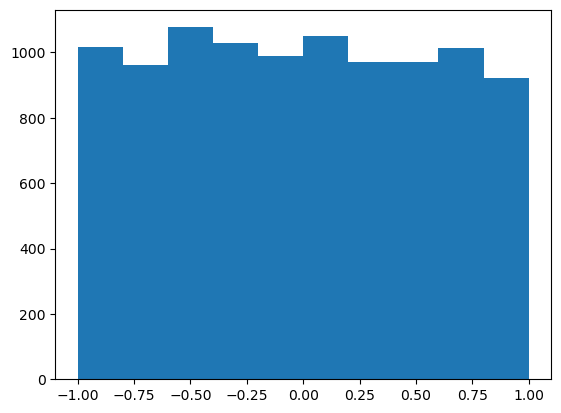

In [342]:
plt.hist(corruni_m1p1[:,0]);

# Univariate Conditional Flows 

In [41]:
nvars = 1
key, subkey = jr.split(jr.PRNGKey(901830128))

base_dist = flowjax.distributions._StandardUniform((1,))

# base_dist = Uniform(-jnp.zeros(nvars), jnp.ones(nvars))
marginal_transform = Stack([UnivariateNormalCDF(
    ate=5., 
    const=3., 
    scale=3., 
    cond_dim=1
)])
flow = Transformed(base_dist, Invert(marginal_transform))

key, subkey = jr.split(key)

# Train 
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=y,
    condition=x,
    learning_rate=1e-2,
    max_patience=20,
    max_epochs=700,
)

 10%|██████▌                                                        | 73/700 [00:05<00:46, 13.53it/s, train=1.9581364, val=1.9772975 (Max patience reached)]


In [42]:
flow.bijection.bijection.bijections[0].ate, flow.bijection.bijection.bijections[0].scale

(Array(1.0402632, dtype=float32), Array(1.750379, dtype=float32))

In [43]:
flow.bijection.bijection.bijections[0].const

Array(-0.01927223, dtype=float32)

# Discrete flows

In [153]:
import numpy as np

In [188]:
total_population = 1000
num_success_states = 30
num_draws = 10

# Generate a sample of 1000 from the hypergeometric distribution
ord_y = jnp.expand_dims(np.random.hypergeometric(num_success_states, total_population - num_success_states, 
                                                num_draws, size=(1000,)),
                                               axis=1)

In [189]:
denoised_y = ord_y + jnp.expand_dims(jr.uniform(jr.PRNGKey(34750), shape=(1000,)),axis=1) - 1
                                               

In [190]:
nvars = 1
key, subkey = jr.split(jr.PRNGKey(SEED + 1))

base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=8, interval=1)

flow = masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    ) # Support on [-1, 1]

# flow = Transformed(
#     flow, Invert(Tanh(flow.shape))
# ) # Unbounded support

flow = Transformed(
    flow, Affine(loc=+jnp.ones(nvars), scale=jnp.ones(nvars)*2)
) # Unbounded support



flow = flow.merge_transforms()

assert isinstance(flow.base_dist, _StandardUniform)

flow = eqx.tree_at(
    where=lambda flow: flow.bijection.bijections[0],
    pytree=flow,
    replace_fn=NonTrainable,
    )

flow = eqx.tree_at(
    where=lambda flow: flow.bijection.bijections[-1],
    pytree=flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=denoised_y,
    learning_rate=1e-4,
    max_patience=10,
    max_epochs=10000,
)



 14%|█████▊                                     | 1365/10000 [01:42<10:45, 13.37it/s, train=0.71208525, val=0.62075096 (Max patience reached)]


In [191]:
flow_samples = flow.sample(jr.PRNGKey(SEED + 99569), (1000, )).T
disc_flow_samples = jnp.where(flow_samples <=0., 0., jnp.ceil(flow_samples))

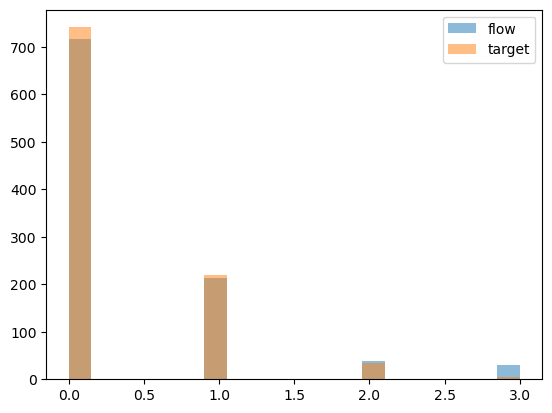

In [192]:
plt.hist(disc_flow_samples.astype(int), label="flow", alpha=0.5, bins=20)
plt.hist(ord_y.T, label="target", alpha=0.5, bins=20)
plt.legend()

In [212]:
uni_s = jr.uniform(key, shape=(1000,1))
uni_m1p1 = jax.vmap(flow.bijection.bijections[0].tree.transform)(uni_s)
corruni_m1p1 = jax.vmap(flow.bijection.bijections[1].transform)(uni_m1p1)
corruni_01 = jax.vmap(flow.bijection.bijections[2].tree.transform)(corruni_m1p1)

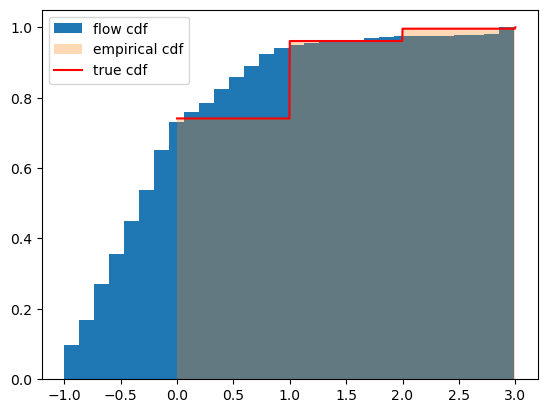

In [224]:
# Generate x values
x = np.linspace(min(ord_y), max(ord_y), num=1000)

# Compute y values
y = ecdf(x)


plt.hist(corruni_01.T, cumulative=True, density=True, bins=30, label='flow cdf');
plt.hist(ord_y.T, cumulative=True, density=True, bins=30, label='empirical cdf', alpha=0.3);
plt.plot(x, y, color='red', label='true cdf')
plt.legend()